# Imports

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import GPyOpt
from timeit import default_timer as timer

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle

import random

# Data Preprocessing

In [2]:
def DataPreprocessing(train_pr_label,test_pr_label,pool_size_pr_label,random_state):

    pool_size_pr_label += train_pr_label

    # load train and test sets
    train = pd.read_csv('Data/fashion-mnist_train.csv').to_numpy()
    test = pd.read_csv('Data/fashion-mnist_test.csv').to_numpy()

    X_train = train[:,1:]
    y_train = train[:,0]
    X_test = test[:,1:]
    y_test = test[:,0]

    X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
    X_test, y_test = shuffle(X_test, y_test, random_state=random_state)

    where_train = []
    where_test = []
    where_pool = []

    for label in range(10):
        where_train.append(np.where(y_train == label)[0][:train_pr_label])
        where_test.append(np.where(y_test == label)[0][:test_pr_label])
        where_pool.append(np.where(y_train == label)[0][train_pr_label:pool_size_pr_label])

    def flatten(array):
        new_array = []
        for sublist in array:
            for item in sublist:
                new_array.append(item)
        return new_array
        
    where_train = flatten(where_train)
    where_test = flatten(where_test)
    where_pool = flatten(where_pool)

    X_pool = X_train[where_pool]
    y_pool = y_train[where_pool]

    X_train = X_train[where_train]
    y_train = y_train[where_train]

    X_test = X_test[where_test]
    y_test = y_test[where_test]
        
    print("Train data shape:", X_train.shape, "Test data shape:", X_test.shape)
    print("Train labels shape:", y_train.shape,"  Test labels shape:", y_test.shape)
    print("Pool data shape:", X_pool.shape,"  Pool labels shape:", y_pool.shape)
    
    print(f"{np.count_nonzero(X_pool == label)}")
    
    return X_train,y_train,X_test,y_test,X_pool,y_pool

# Loading Bar

In [3]:
class _loading:
    
    def __init__(self, count, headline):
        self.count = count
        self.current = 0
        self.skip = 0
        print("\n{0} in progress...".format(headline))
        
    def _update(self):
        self.current += 1
        if self.current == self.count:
            print("\r{0}".format("Finished Successfully!                               \n"))
        elif self.skip > self.count/133:
            print("\r{0}".format("|{0}{1}|   {2}% finished.".format("█"*int(round(self.current/self.count,1)*20),"-"*(20-int(round(self.current/self.count,1)*20)),round((self.current/self.count)*100,2))), end = "", flush=True)
            self.skip = 0
            
        else:
            self.skip += 1

# Query By Comittee

In [6]:
class Sampler:
    
    model_number = 0
    models = []
    X_pool = []
    y_pool = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    X_train_old = []
    y_train_old = []
    
    compare_count = 0
    compare_labels = {}
    
    loading_bar = _loading(0,"")
    
    def __init__(self,model_number,X_train,y_train,X_pool,y_pool,X_test,y_test):
        
        self.model_number = max(model_number,20)
        
        self.X_pool = X_pool
        self.y_pool = y_pool
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_old = X_train
        self.y_train_old = y_train
        
        self.X_test = X_test
        self.y_test = y_test

        self.initialize_models()
        
        
    def shuffle_data(self):
        zip_list = list(zip(self.X_pool, self.y_pool))
        random.shuffle(zip_list)
        self.X_pool, self.y_pool = zip(*zip_list)
        
        
    def initialize_models(self):
        params = [["newton-cg","l2"],["newton-cg","none"],["lbfgs","l2"],["lbfgs","none"],["liblinear","l1"],["liblinear","l2"],["sag","l2"],["sag","none"],["saga","elasticnet"],["saga","l1"]]
        trees = np.arange(200,301,10)
        
        for i in range(int(np.floor(self.model_number/2))):
            if params[i][1] == "elasticnet":
                model = LogisticRegression(random_state=i, solver = params[i][0], penalty = params[i][1], l1_ratio=0.2)
            else:
                model = LogisticRegression(random_state=i, solver = params[i][0], penalty = params[i][1])
            self.models.append(model)
            
        for i in range(int(np.floor(self.model_number/2))):
            model = RandomForestClassifier(n_estimators = trees[i])
            self.models.append(model)

        self.train_models()
            
    def train_models(self):
        for model in self.models:
            model.fit(self.X_train,self.y_train)
    
    def reset_models(self):
        self.X_train = self.X_train_old
        self.y_train = self.y_train_old
        self.train_models()

    def acc_model(self):
        scores = []
        for model in self.models:
            preds = model.predict(X_test)
            scores.append(accuracy_score(preds,self.y_test))
        
        return np.mean(scores)
            
    
    def find_pool_idx(self,heuristic):
        y_preds = np.array([])
        if heuristic in ["qbc_majority, qbc_vote_entropy","random"]:
            for model in self.models:
                y_pred = model.predict(self.X_pool)
                if len(y_preds) == 0:
                    y_preds = np.append(y_preds,y_pred)
                else:
                    y_preds = np.vstack((y_preds,y_pred))
        else:
            model = self.models[0]
            y_preds = model.predict_proba(self.X_pool)

        if heuristic == "qbc_majority":
            minimum = 11
            pool_index = 0
            for pred in range(len(y_preds[0])):
                maks = 0
                for label in range(10):
                    count = np.count_nonzero(y_preds[:,pred] == label)
                    if count > maks:
                        maks = count
                if maks < minimum:
                    minimum = maks
                    pool_index = pred     
                    
        elif heuristic == "qbc_vote_entropy":
            values = []
            for pred in range(len(y_preds[0])):
                value = 0
                for label in range(10):
                    count = np.count_nonzero(y_preds[:,pred] == label)
                    value += count/self.model_number*np.log(count/self.model_number) if count != 0 else 0
                values.append(-value)
            
            pool_index = np.argmax(np.array(values))
            
        elif heuristic == "random":
            pool_index = np.random.randint(len(self.X_pool))
            
        elif heuristic == "uncertainty_lc":
            pool_index = np.argsort(-y_preds.max(1))[-1]
            
        elif heuristic == "uncertainty_entropy":
            pool_index = np.argmax(-np.sum(y_preds*np.log(y_preds), axis = 0))
        
            
        self.X_train = np.vstack((self.X_train,self.X_pool[pool_index]))
        self.y_train = np.append(self.y_train,self.y_pool[pool_index])
        
        self.train_models()
        
        self.X_pool = np.delete(self.X_pool, pool_index, axis=0)
        self.y_pool = np.delete(self.y_pool, pool_index, axis=0)
        
        return y_pool[pool_index]
        
    def query(self,itts,heuristics):
        self.reset_models()
        self.shuffle_data()
        
        accs = []
        accs.append(self.acc_model())
        labels = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
        for i in range(itts):
            #print(f"heuristic: {heuristics}, itt: {i} out of {itts}")
            label = self.find_pool_idx(heuristics)
            accs.append(self.acc_model())
            labels[label] += 1
            self.loading_bar._update()
        return accs, labels
    
    def compare_models(self,itts,compare_itt,repeats):
        self.loading_bar = _loading(5*itts,f"Comparing QBC Models // Repetition {compare_itt} out of {repeats}")
        
        # query by committee
        majority_accs, majority_labels = self.query(itts,"qbc_majority")
        vote_entropy_accs, vote_entropy_labels = self.query(itts,"qbc_vote_entropy")
        # uncertainty sampling with least confident
        uncertainty_lc_accs, uncertainty_lc_labels = self.query(itts,"uncertainty_lc")
        uncertainty_entropy_accs, uncertainty_entropy_labels = self.query(itts,"uncertainty_entropy")
        random_accs, random_labels = self.query(itts,"random")

        print(f"\n\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\ Repetition {compare_itt} ////////////////")

        print(f"Majority Voting Samples: {majority_labels}")
        print(f"Vote Entropy Samples: {vote_entropy_labels}")
        print(f"Uncertainty sampling with LC: {uncertainty_lc_labels}")
        print(f"Uncertainty sampling with entropy: {uncertainty_entropy_labels}")
        print(f"Random Samples: {random_labels}")

        print(f"Majority Voting Accuracy: {majority_accs[-1]}")
        print(f"Vote Entropy Accuracy: {vote_entropy_accs[-1]}")
        print(f"Uncertainty sampling with LC: {uncertainty_lc_accs[-1]}")
        print(f"Uncertainty sampling with entropy: {uncertainty_entropy_accs[-1]}")
        print(f"Random Accuracy: {random_accs[-1]}\n")
        
        self.plot_models([majority_accs,
                          vote_entropy_accs,
                          uncertainty_lc_accs,
                          uncertainty_entropy_accs,
                          random_accs],compare_itt,repeats)
    
    def compare_models_repeat(self, itts, repeats):
        for rep in range(repeats):
            self.compare_models(itts,rep+1,repeats)

    def plot_models(self,accs,compare_itt,repeats):
        
        if compare_itt == repeats:
            plt.plot(accs[0], label='Majority Voting', color = "red")
            plt.plot(accs[1], label='Vote Entropy', color = "blue")
            plt.plot(accs[2], label='Uncertainty LC', color = "orange")
            plt.plot(accs[3], label='Uncertainty entropy', color = "purple")
            plt.plot(accs[4], label='Random', color = "green")
            plt.ylabel('accuracy')
            plt.xlabel("Pool Samples")
            plt.legend(loc="upper left")
            plt.show()
        else:
            plt.plot(accs[0], color = "red")
            plt.plot(accs[1], color = "blue")
            plt.plot(accs[2], color = "orange")
            plt.plot(accs[3], color = "purple")
            plt.plot(accs[4], color = "green")
    
    
    


 in progress...


Train data shape: (50, 784) Test data shape: (5000, 784)
Train labels shape: (50,)   Test labels shape: (5000,)
Pool data shape: (1000, 784)   Pool labels shape: (1000,)
754

Comparing QBC Models // Repetition 1 out of 1 in progress...
Finished Successfully!                               


\\\\\\\\\\\\\\\\ Repetition 1 ////////////////
Majority Voting Samples: {0: 2, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
Vote Entropy Samples: {0: 2, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
Uncertainty sampling with LC: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1}
Uncertainty sampling with entropy: {0: 2, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
Random Samples: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0}
Majority Voting Accuracy: 0.6580600000000001
Vote Entropy Accuracy: 0.66595
Uncertainty sampling with LC: 0.66107
Uncertainty sampling with entropy: 0.66754
Random Accuracy: 0.6554099999999999



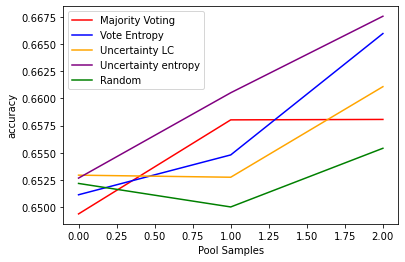

In [7]:
# Number of itterations (datapoints from pool) to sample.
number_of_samples = 2
# Number of models /// Number between 1-20.
number_of_models = 20
# Number of repeats of comparison.
number_of_repeats = 1

train_pr_label = 5
test_pr_label = 500
pool_size_pr_label = 100
random_state = 10


X_train,y_train,X_test,y_test,X_pool,y_pool = DataPreprocessing(train_pr_label,test_pr_label,pool_size_pr_label,random_state)

comittee = Sampler(number_of_models,X_train,y_train,X_pool,y_pool,X_test,y_test)
comittee.compare_models_repeat(number_of_samples, number_of_repeats)

In [ ]:
plt.savefig("d.png")